# risk_aware_bandits

## Risk-aware Multi-Armed Bandit Algorithms

Let us explore an alternate case of the Multi-Armed Bandit problem where we have reward distributions with different risks. I'll draw inspiration from [Galichet et. al's (2013) work](http://proceedings.mlr.press/v29/Galichet13.pdf) and implement the MaRaB algorithm and compare it to Thompson Sampling and Bayesian UCB.

## Why is this relevant?

You can frame many industry problems as bandit problems. Any problem which involves experimentation and online data gathering (in the sense that you need to take some action and incur some cost in order to access it) calls for this type of treatment. Instantly, we can think of testing different layouts of a website, actively recommending new products to clients, or dynamically setting prices in an online marketplace as examples in which these techniques are useful. 

Suppose we're applying a bandit treatment to allocating money in stocks, which may have different risks for their return distributions. Just as we have uncertainty over the expected rewards, we also have uncertainty over the variance of rewards as well. Using risk-aware bandits, we can encourage the algorithm to explore and exploit according to our risk appetite, controlling our exposure.

In [1]:
# plotting inline but with a non-gui backend
#import matplotlib as mpl; mpl.use('Agg')
%matplotlib inline

# importing necessary modules
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# turning off automatic plot showing, and setting style
plt.style.use('bmh')
plt.ioff()

## Gaussian Bandit with different risks

Let us borrow the problem from our previous post but change it up a bit by building a bandit problem where reward distributions have diffrent variances. Each bandit $k$ is modeled as a random variable $Y_k \sim \mathcal{N}(\mu_k, \sigma_k^2)$, as in my [last post](https://gdmarmerola.github.io/approximate-bayes-bandits/), but with the following twists:

1. **We use different $\sigma_k$'s for each bandit:** particularly, I'll build the problem such that bandits with higher $\mu_k$ also have higher $\sigma_k$
2. **We use a different measure of regret:** since we started considering risk, our regret measure must reflect that. Thus, we use Conditional Value-at-Risk (CVaR) as our regret measure:

$$\large \textrm{Regret} = \textrm{CVaR}_{best}(\alpha) - \textrm{CVaR}_{k}(\alpha)$$

where $\textrm{CVaR}_{best}(\alpha)$ is the best CVaR and $\textrm{CVaR}_{k}(\alpha)$ is the CVaR of chosen bandit $k$. The quantity $\alpha \in [0, 1]$ controls the amount of risk we desire to take. We define $\textrm{CVaR}_{k}(\alpha)$ as the average reward of bandit $k$ on the worst $\alpha \times 100\%$ of its possible outcomes (lower $\alpha$-quantile):

$$\large \textrm{CVaR}_{k}(\alpha) = \mathbb{E}[Y_k\ \vert\ Y_k \leq VaR_{Y_k}(\alpha)]$$

$VaR_{Y_k}(\alpha)$ is the Value-at-Risk of $Y_k$, which is equal to its $\alpha$-quantile.

When $\alpha \to 1$, we do not care about risk and aim to choose the bandit with maximal expected rewards $\textrm{argmax}_k(\mu)$. Conversely, when $\alpha \to 0$, we are completely risk-averse and aim to choose the bandit with the best minimum (worst-case) reward. The following code implements the game:

In [2]:
# class for our row of bandits
class GaussianMABCVaR:
    
    # initialization
    def __init__(self, mu, sigma, alpha):
        
        # storing mean and standard deviation vectors
        self.mu = mu
        self.sigma = sigma
        self.dist = [norm(self.mu[i], self.sigma[i]) for i in range(len(self.mu))]
        self.cvar_bandits = [self.cvar(i, alpha) for i in range(len(self.mu))]
        self.alpha = alpha
        
    # function that helps us draw from the bandits
    def draw(self, k):

        # we return the reward and the regret of the action
        return self.dist[k].rvs(1)[0], self.cvar_regret(k)
    
    # CVaR calculation for risk-aware bandits
    def cvar(self, k, alpha):
        
        # grid for calculating cvar at lowest alpha-quantile
        grid = np.linspace(0.001, 0.999, 1001)
        
        # quantile values over the grid
        percentiles = self.dist[k].ppf(grid)
        
        # CVaR is average of quantile values below the alpha-quantile
        return percentiles[grid < alpha].mean()
    
    # CVaR regret from choice to best CVaR
    def cvar_regret(self, k):
                
        # returning our choice vs. best bandit
        return np.max(self.cvar_bandits) - self.cvar_bandits[k]

We can create an instance of our game just like in the previous post, only adding an `alpha` variable to guide CVaR calculation:

In [3]:
# parameters
mu_rewards = [0.00,-0.15,0.30,0.15]
sd_rewards = [0.20, 0.10,0.60,0.35]
alpha = 0.05

# instance of our risky MAB
gmab = GaussianMABCVaR(mu_rewards, sd_rewards, alpha)

I parameterized the game such that bandits with highest expected rewards also have higher risk. Thus, the optimal bandit will change with our risk appetite parameter $\alpha$. Let us check our reward distributions highlighting their $\alpha$-quantile and their CVaR value:

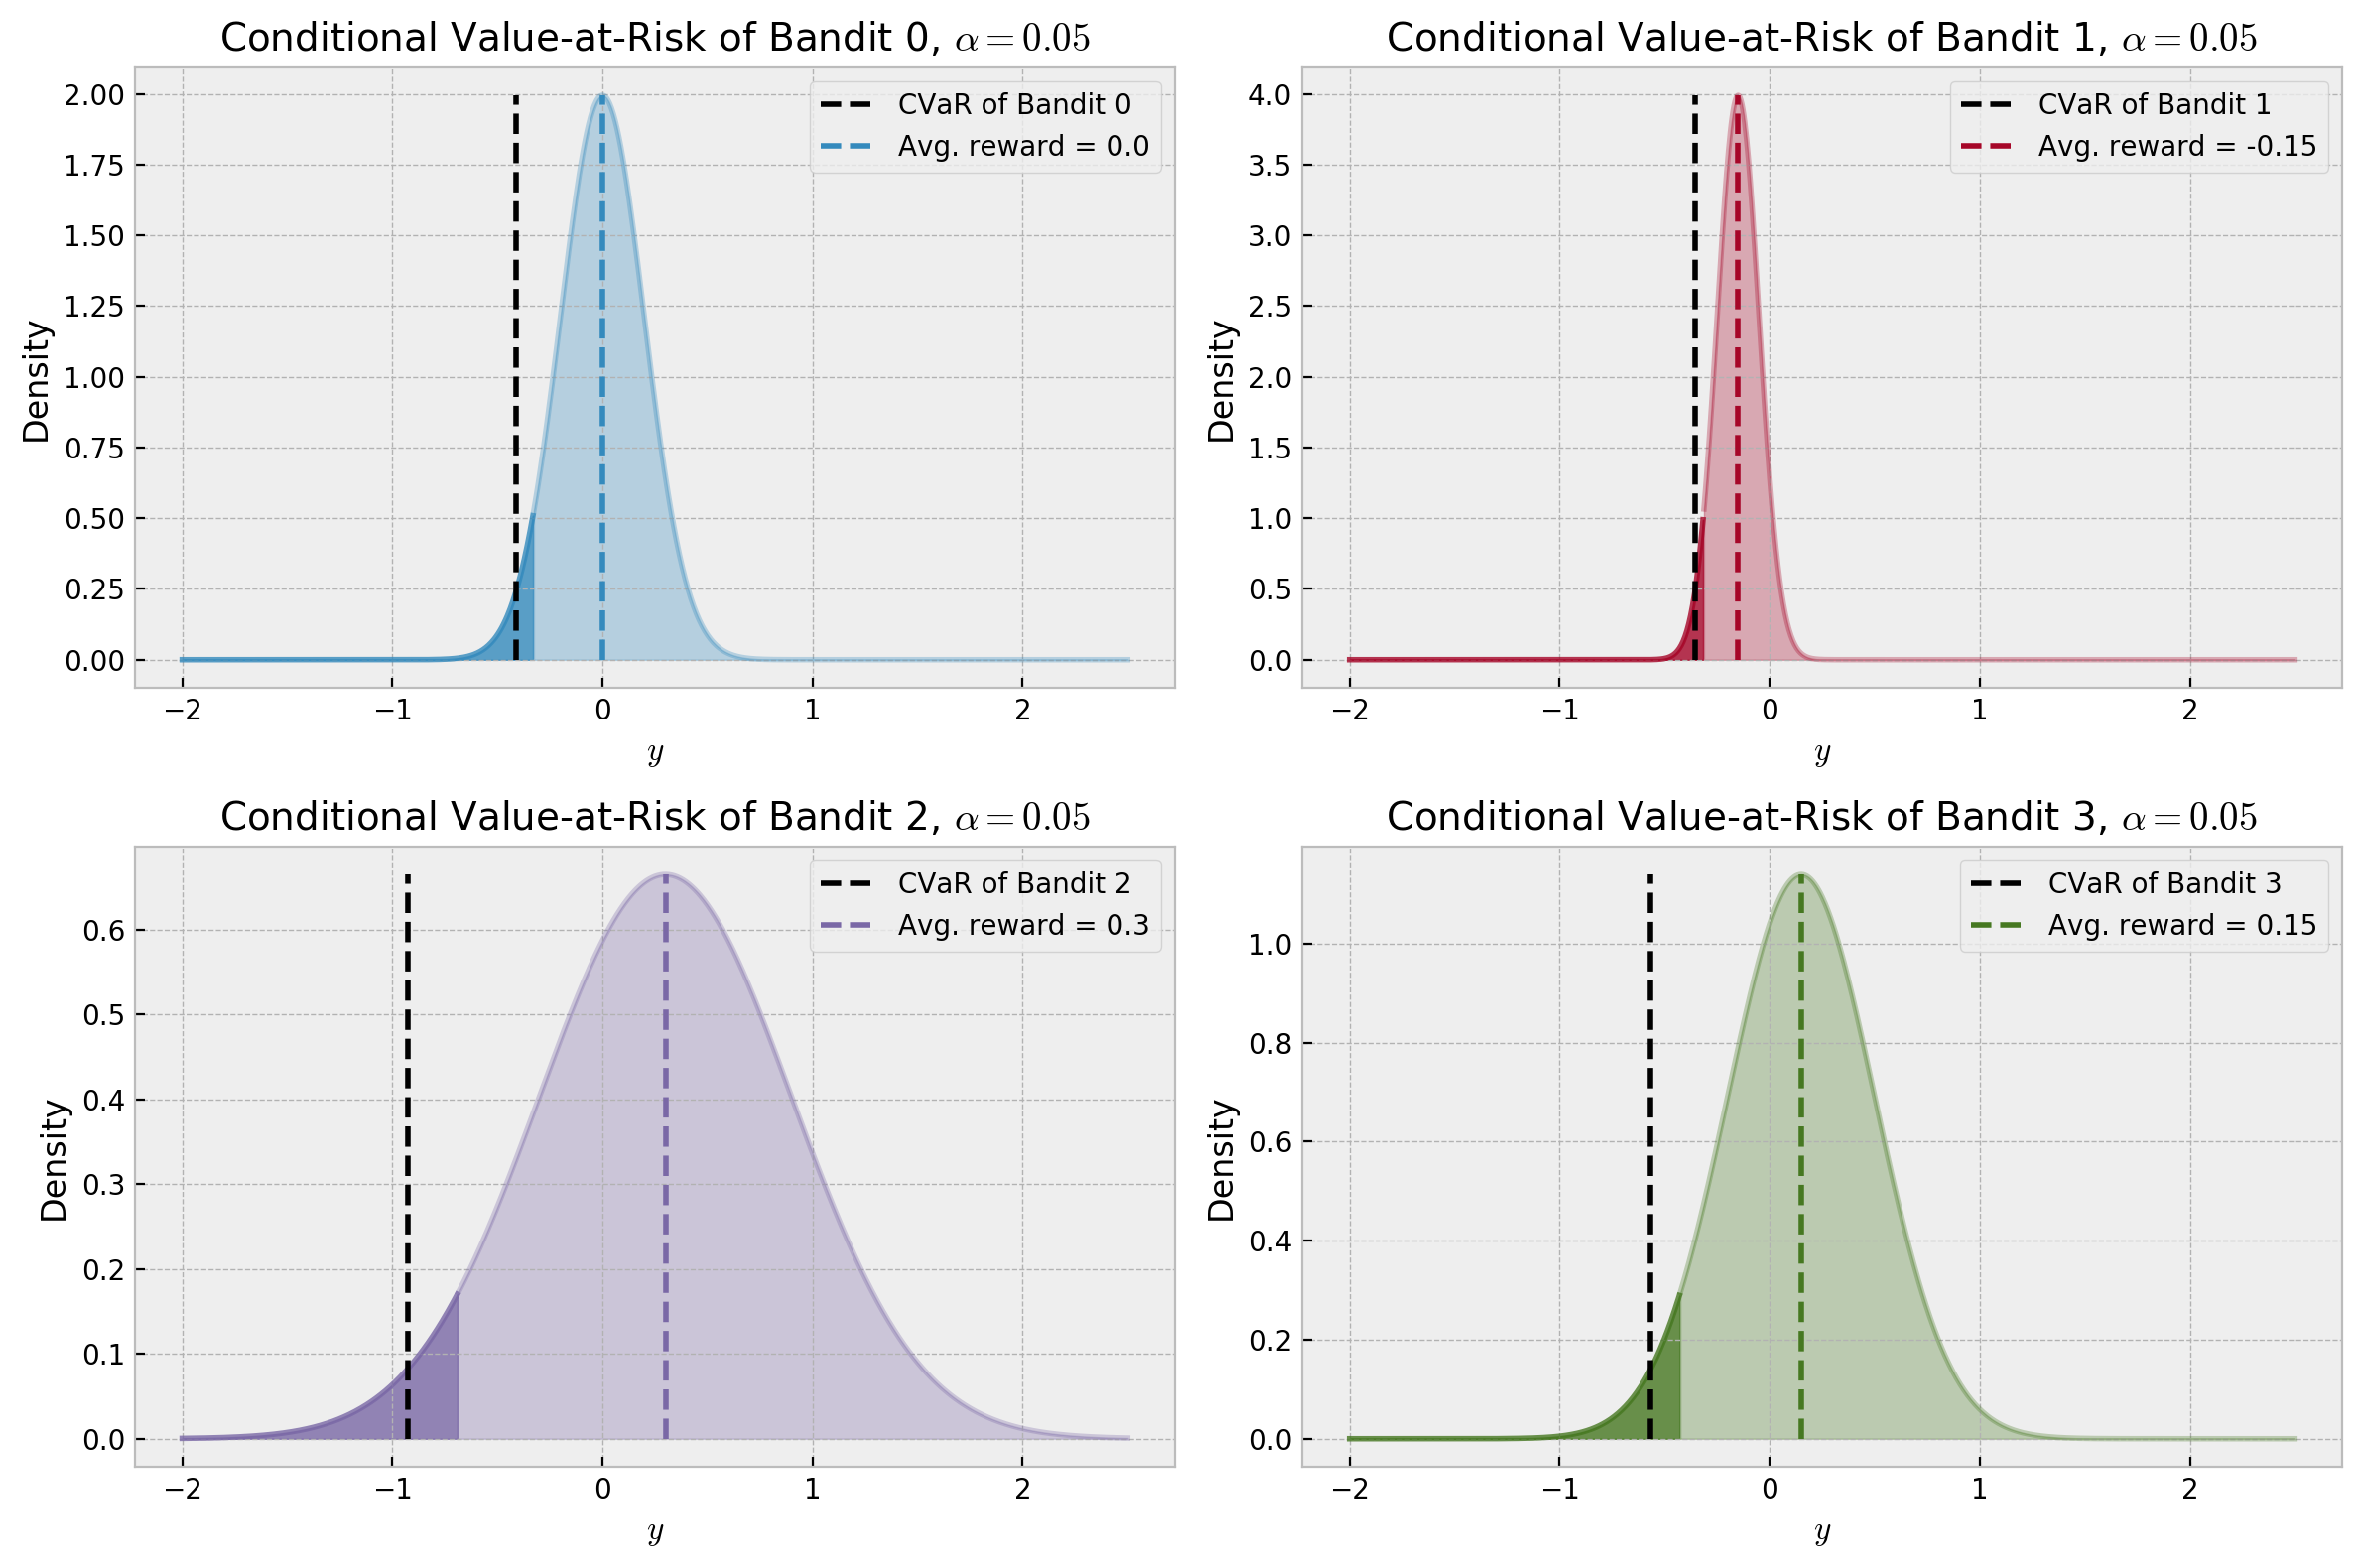

In [4]:
# x grid for plotting densities
x_grid = np.linspace(-2.00, 2.50, 1001)

# opening figure
fig = plt.figure(figsize=(12,8), dpi=200)

# loop for each distribution
for i, dist in enumerate(gmab.dist):
    
    # opening subplot
    plt.subplot(2, 2, i+1)
    
    # calulating density and alpha-quantile
    dens = dist.pdf(x_grid)
    alpha_q = dist.ppf(gmab.alpha)
    
    # plotting densities above and below alpha-quantile #
    
    # above alpha-quantile, more transparency
    plt.plot(x_grid[x_grid > alpha_q], dens[x_grid > alpha_q], color='C{}'.format(i), alpha=0.3)
    plt.fill_between(x_grid[x_grid > alpha_q], dens[x_grid > alpha_q], color='C{}'.format(i), alpha=0.3)
    
    # below alpha-quantile, less transparency
    plt.plot(x_grid[x_grid <= alpha_q], dens[x_grid <= alpha_q], color='C{}'.format(i), alpha=0.8)
    plt.fill_between(x_grid[x_grid <= alpha_q], dens[x_grid <= alpha_q], color='C{}'.format(i), alpha=0.8)
    
    # plotting CVaR
    plt.plot([gmab.cvar_bandits[i], gmab.cvar_bandits[i]], [0, np.max(dens)], 'k--', 
             label='CVaR of Bandit {}'.format(i))
    
    # plotting average reward
    plt.plot([gmab.mu[i], gmab.mu[i]], [0, np.max(dens)], linestyle='dashed', color='C{}'.format(i),
             label='Avg. reward = {}'.format(np.round(gmab.mu[i], 2)))
    
    # formatting the plots title and etc
    plt.legend(); plt.tight_layout()
    plt.title('Conditional Value-at-Risk of Bandit {}, $\\alpha = {}$'.format(i, np.round(gmab.alpha, 2)), fontsize=14)
    plt.xlabel('$y$'); plt.ylabel('Density')

For the conservative value of $\alpha = 0.05$, the optimal bandit is actually the one with lowest expected reward. How would CVaR values change with $\alpha$, for each bandit? Let us check in the plot below:

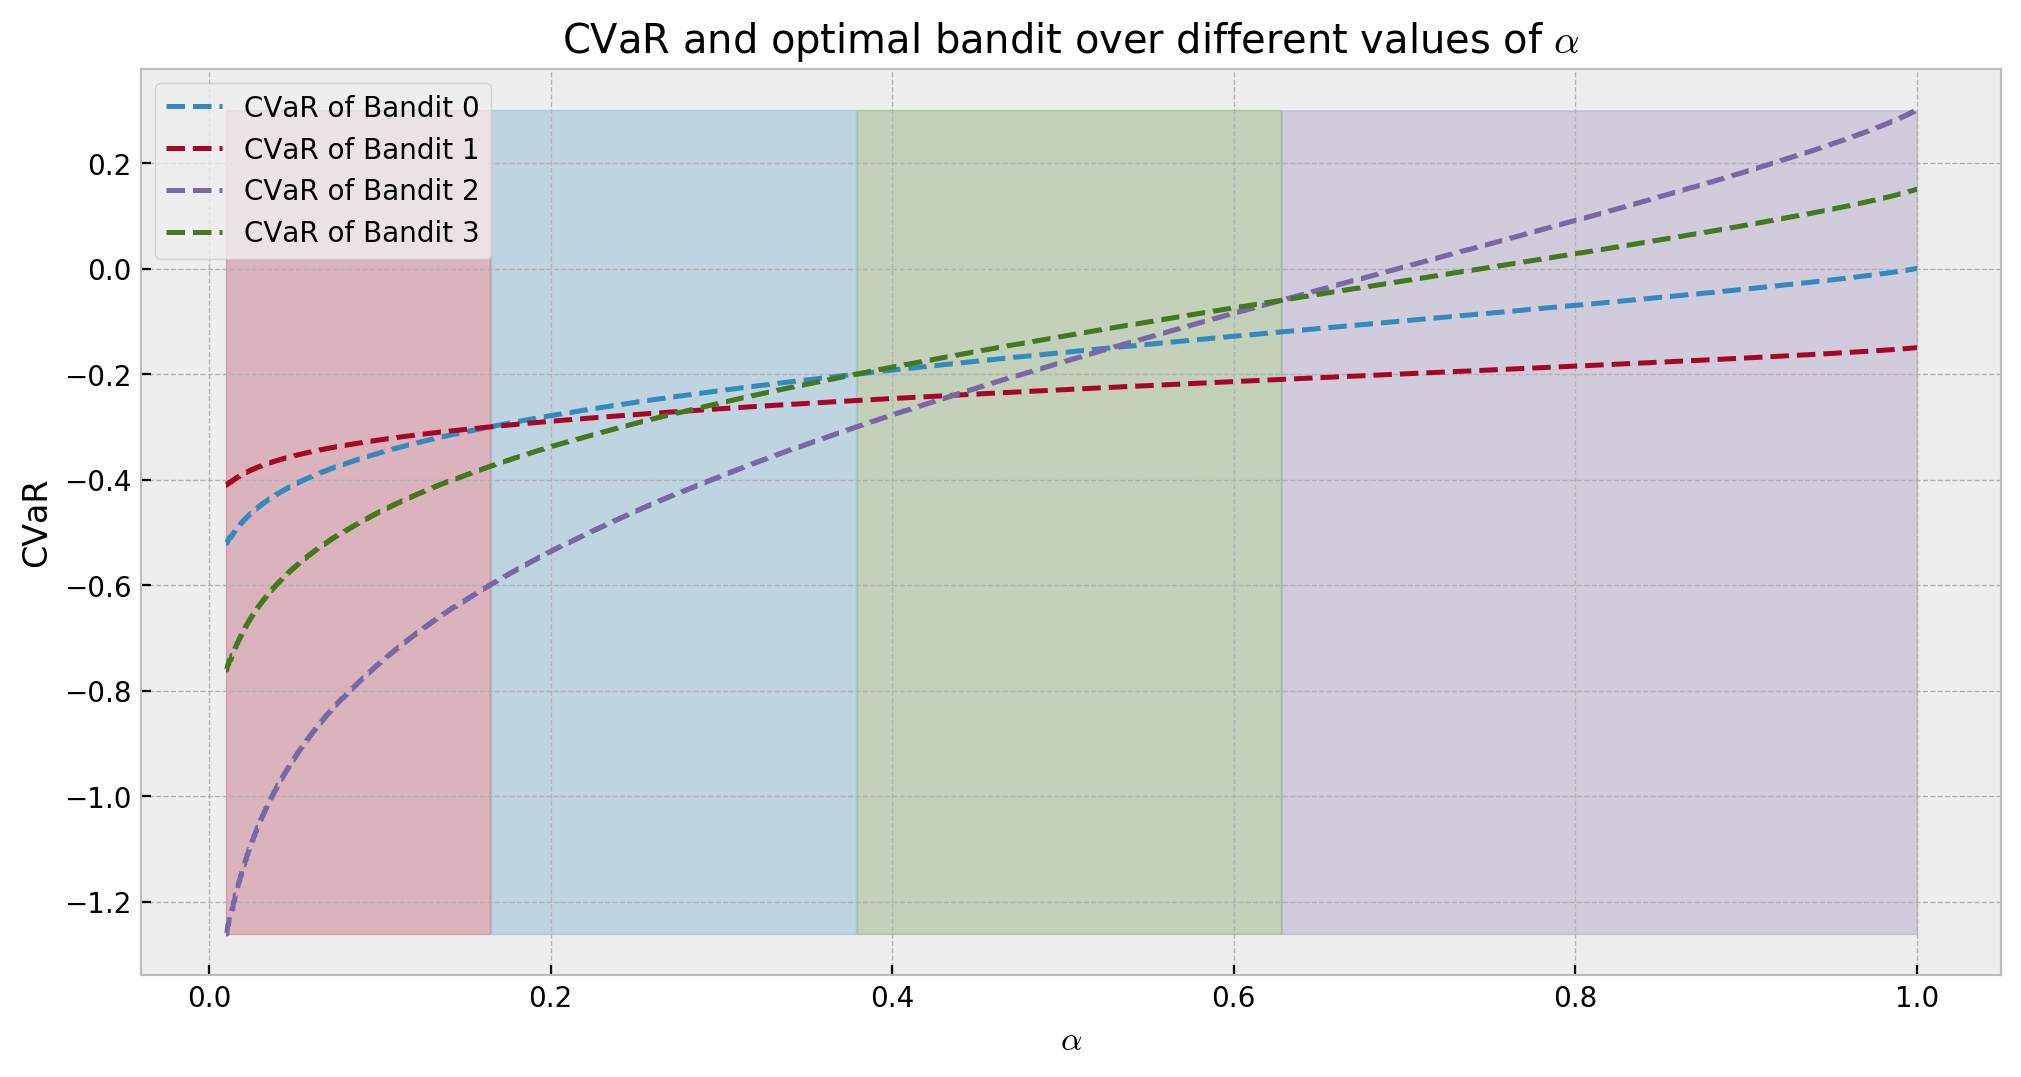

In [5]:
# alpha grid to calculate CVaR
alpha_grid = np.linspace(0.01, 1, 2000)

# list for storing cvar grids
cvar_list = []

# opening figure
fig = plt.figure(figsize=[12,6], dpi=200)

# calculating cvar for different alpha values and bandits and plotting
for bandit in range(len(gmab.mu)):
    
    # calculating cvar over grid
    cvar_grid = [gmab.cvar(bandit, a) for a in alpha_grid]
    cvar_list.append(cvar_grid)
    
    # plotting
    plt.plot(alpha_grid, cvar_grid, color='C{}'.format(bandit), linestyle='dashed', linewidth=1.8, 
             label='CVaR of Bandit {}'.format(bandit))
    
# finding best bandit per alpha value
best_bandit = np.argmax(np.array(cvar_list), axis=0)

# plotting best bandit shade
for bandit in np.unique(best_bandit):
    plt.fill_between(alpha_grid[best_bandit == bandit],
                     [np.array(cvar_list).max()] * np.sum(best_bandit == bandit),
                     [np.array(cvar_list).min()] * np.sum(best_bandit == bandit),
                     color='C{}'.format(bandit), alpha=0.25)#, label='Best bandit = {}'.format(bandit))

# formatting
plt.legend();
plt.title('CVaR and optimal bandit over different values of $\\alpha$')
plt.xlabel('$\\alpha$'); plt.ylabel('CVaR');

The shaded areas indicate which bandit is optimal at each risk appetite. As our risk increases with expected rewards, we see that the bandits with higher $\mu_k$ turn optimal in more aggressive scenarios. Also, we observe that the optimal CVaR is less than zero up until a certain $\alpha$ around 0.65. In a real application, if we had such conservative risk appetite, it would be better to take no action.

## Multi-Armed Risk-Aware Bandit (MaRaB)

The Multi-Armed Risk-Aware Bandit (MaRaB) algorithm was introduced by Galichet et. al's in their 2013 paper "[Exploration vs Exploitation vs Safety: Risk-Aware Multi-Armed Bandits](http://proceedings.mlr.press/v29/Galichet13.pdf)". It selects bandits according to the following formula:

$$\large \textrm{select}\ k_t = \textrm{argmax}\Bigg\{ \widehat{\textrm{CVaR}_k(\alpha)} - C\sqrt{\frac{log(\lceil t\alpha \rceil)}{n_{k,t,\alpha}}}\Bigg\}$$

The quantity $\widehat{\textrm{CVaR}_k(\alpha)}$ is the average of the empirical $\alpha$-quantile given observations at time $t$, $\sqrt{\frac{log(t\alpha)}{n_{i,t,\alpha}}}$ is a lower confidence bound on the CVaR, $n_{k,t,\alpha}$ is the number of observations (rounded to ceiling integer) in the $\alpha$-quantile for bandit $k$ at time $t$, and $C$ is a parameter controlling exploration.

We can see that this algorithm is very conservative: it features a negative exploration term, which disencourages exploration, such that if two bandits have the same estimated CVaR, it will favor the one which has been selected more often in the past. However, while the $\alpha$-quantile contains only one sample, it will explore a bit as the CVaR will be a monotonically decreasing function with respect to the number of plays, making bandits that were selected few times look better. The implementation follows:

In [6]:
# class for the marab algorithm
class MaRaB:
    
    # initalizing
    def __init__(self, alpha, C):
    
        # storing parameter values
        self.alpha = alpha
        self.C = C
        
    # function for calculating CVaR
    def get_empirical_cvar(self, obs):
        
        # calculating
        return np.array(sorted(obs))[:np.ceil(self.alpha*len(obs)).astype(int)].mean()
        
    # function for choosing next action
    def choose_bandit(self, k_list, reward_list, n_bandits, round_id=0):
        
        # converting to arrays
        k_list = np.array(k_list)
        reward_list = np.array(reward_list)
        
        # list accumulating scores
        scores_list = []
                
        # loop for each bandit to perform inference
        for k in range(n_bandits):
            
            # filtering observation for this bandit
            obs = reward_list[k_list == k]
            
            # if we have at least one observation
            if len(obs) > 0:
            
                # calculating empirical cvar
                empirical_cvar = self.get_empirical_cvar(obs)

                # calculating lower confidence bound
                lcb = np.sqrt(np.log(np.ceil(self.alpha*len(k_list)))/np.sum(k_list == k))

                # adding score to scores list
                scores_list.append(empirical_cvar - self.C * lcb)
                
            # if not, score is infinity so we sample this arm at least once
            else:
                scores_list.append(np.inf)
        
        # casting to array type
        scores_list = np.array(scores_list)
        
        # returning bandit choice
        return np.random.choice(np.flatnonzero(scores_list == scores_list.max()))    

Let us observe it playing for 200 rounds with the following animation of rewards over time. In the animation, each horizontal line represents one of our four bandits and rewards are represented by dots with size proportional to the reward. We use $\alpha = 0.50$, so the green bandit should be optimal.

In [7]:
# parameters
mu_rewards = [0.00,-0.15,0.30,0.15]
sd_rewards = [0.20, 0.10,0.60,0.35]
alpha = 0.50

# instance of our risky MAB
gmab = GaussianMABCVaR(mu_rewards, sd_rewards, alpha)

# instance of MaRaB algo
marab = MaRaB(gmab.alpha, 1e-6)

In [8]:
# number of draws
N_DRAWS = 200

# number of bandits
N_BANDITS = len(gmab.mu)

# numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# lists for ease of use, visualization
k_list = []
reward_list = []

# opening figure and setting style
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)

# colors for each bandit
bandit_colors = ['C0', 'C1', 'C2', 'C3']

# loop generating draws
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = marab.choose_bandit(k_list, reward_list, N_BANDITS)
    reward, regret = gmab.draw(k)
    
    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
      
    # getting list of colors that tells us the bandit
    color_list = [bandit_colors[k] for k in k_list]
    
# function for updating
def animate(i):
    
    # clearing plot
    ax.clear()
    
    # initializing with first data
    ax.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], 
               color=color_list[:i], linestyle='-', marker='o', 
               s=100*(((reward_list[:i] - np.min(reward_list))/(np.max(reward_list) - np.min(reward_list))+0.01)**2));

    # titles
    ax.set_title('MaRaB draws from Gaussian bandits with different risks | $\\alpha = {}$'.format(gmab.alpha), fontsize=10);
    ax.set_xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
    ax.set_yticks(list(range(N_BANDITS)));
    ax.set_yticklabels(['{}\n(CVaR = {})'.format(i, np.round(gmab.cvar_bandits[i], 2)) for i in range(N_BANDITS)]);
    ax.tick_params(labelsize=10);
    ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    return ()

# function for creating animation
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=100, blit=True)

# showing
video = HTML(anim.to_html5_video())

# closing figures and then showing video
plt.close();
video

We can see in practice the risk-averse behavior of MaRaB, exploring very little. This lack of exploration may be a problem, making it harder to the algorithm converge to the best bandit.

Let us now experiment with two bayesian algorithms of increasing popularity, and compare them to MaRaB: Bayesian UCB and Thompson Sampling.

## Bayesian UCB and Thompson Sampling

Bayesian algorithms for reinforcement learning are attracting much interest recently, due to their great empirical performance and simplicity. I bring two strong contestants for this post: Bayesian Upper Confidence Bound, for which we draw inspiration from [Kaufmann et. al, 2012](http://proceedings.mlr.press/v22/kaufmann12/kaufmann12.pdf), and Thompson Sampling, which has been thoroughly studied by [Van Roy et. al, 2018](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf).

Both algorithms depend on calculating the posterior distribution for the quantity of interest, which in our case is the Conditional Value-at-Risk for a given risk appetite $\alpha$. In [my last post](https://gdmarmerola.github.io/approximate-bayes-bandits/) I explore approximate inference techniques that could solve this problem. In this case, Bootstrapping seems like a good alternative, as it offers flexibility to compute the potentially complicated CVaR posterior. Therefore, let us start by implementing it.

### Approximating the CVaR posterior with Bootstrapping

The code below is borrowed from my last post. It basically returns bootstrap samples of the data. We avoid uncertainty underestimation in early rounds by setting `min_obs` such that we only start taking bootstrap samples after we have `min_obs` observations. If we have less than `min_obs` observations we take samples of the prior distribution. This heuristic avoids greedy behavior in early rounds of the game, as bootstrapping has low variance with few observations.  

In [9]:
# class for exact gaussian inference
class BootstrapCVaRInference:
    
    # initializing with prior paramters
    def __init__(self, prior_mu, prior_sigma, min_obs):
        
        # storing
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.min_obs = min_obs
                
    # fitting the posterior for the mean
    def get_posterior(self, obs, alpha, n_samples):
        
        # reshaping the observations
        obs = np.array(obs)
        
        # checking if there is any observation before proceeding
        if len(obs) >= self.min_obs:
            
            # running many bootstrap samples
            btrap_samples = np.array([self.get_empirical_cvar(np.random.choice(obs, len(obs)), alpha) for _ in range(n_samples)])
            
            # return posterior density via samples
            return btrap_samples
        
        else:
            
            # return samples from the prior
            return norm(self.prior_mu, self.prior_sigma).rvs(n_samples)
        
    # function for calculating CVaR of samples
    def get_empirical_cvar(self, samples, alpha):
        
        # calculating
        return np.array(sorted(samples))[:np.ceil(alpha*len(samples)).astype(int)].mean()

Let us check how the approximate posterior of the CVaR looks like. The following animation illustrates our posterior inference algorithm. It shows 100 draws from a $\mathcal{N}(0.2,1.0)$ distribution, and the approximate posterior distribution over its CVaR, for risk levels $\alpha = 0.10$, $\alpha = 0.50$, and $\alpha = 0.90$.

In [10]:
# true paramters
TRUE_MU = 0.2
TRUE_SIGMA = 1.0
N_ROUNDS = 100

# instatating our exact inference object 
# and defining prior hyperparameters:
infer = BootstrapCVaRInference(0.0, 1.0, 1)

# true distribution
true_dist = norm(TRUE_MU, TRUE_SIGMA)

# calculating cvar of true distribution #

# grid for calculating cvar at lowest alpha-quantile
grid = np.linspace(0.001, 0.999, 1001)

# quantile values over the grid
percentiles = true_dist.ppf(grid)

# CVaR is average of quantile values below the alpha-quantile
# calculating for alpha = 10% and 50%
true_cvar_10 = percentiles[grid < 0.10].mean()
true_cvar_50 = percentiles[grid < 0.50].mean()
true_cvar_90 = percentiles[grid < 0.90].mean()

# opening figure 
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

# our grid values
x_grid = np.linspace(-2.0, 2.0, 2000)

# lists for accumulating round results
dens_list_10 = []
dens_list_50 = []
dens_list_90 = []
obs_list = []

# list of observations which will grow through the rounds
obs = []

# loop for each round
for round in range(N_ROUNDS):
    
    ## posterior for alpha = 0.10 ##
    
    # updating the object with the data and getting posterior
    dens = infer.get_posterior(obs, 0.10, 1000)
    
    # saving result in list
    dens_list_10.append(dens)

    ## posterior for alpha = 0.50 ##
    
    # updating the object with the data and getting posterior
    dens = infer.get_posterior(obs, 0.50, 1000)
    
    # saving result in list
    dens_list_50.append(dens)
    
    ## posterior for alpha = 0.50 ##
    
    # updating the object with the data and getting posterior
    dens = infer.get_posterior(obs, 0.90, 1000)
    
    # saving result in list
    dens_list_90.append(dens)

    # saving observations in list
    obs_list += [np.array(obs)]
    
    # generating some data
    new_obs = list(true_dist.rvs(1))
    obs += new_obs
        
# function for updating
def animate(i):
    
    # clearing the plot
    ax.clear()
    
    ## alpha = 0.10 ##
    
    # plotting approximate posterior
    ax.hist(dens_list_10[i], label='CVaR posterior, $\\alpha = {}$'.format(0.10), 
            alpha=0.5, bins=np.linspace(-2.0,2.0,200), density=True, color='C0')
    
    # plotting the true CVaR
    ax.plot([true_cvar_10, true_cvar_10], [0, 4], 'k--', color='C0',
            label='True CVaR, $\\alpha = {}$'.format(0.10))

    ## alpha = 0.50 ##
    
    # plotting approximate posterior
    ax.hist(dens_list_50[i], label='CVaR posterior, $\\alpha = {}$'.format(0.50), 
            alpha=0.5, bins=np.linspace(-2.0,2.0,200), density=True, color='C2')
    
    # plotting the true CVaR
    ax.plot([true_cvar_50, true_cvar_50], [0, 4], 'k--', color='C2',
            label='True CVaR, $\\alpha = {}$'.format(0.50))

    ## alpha = 0.90 ##
    
    # plotting approximate posterior
    ax.hist(dens_list_90[i], label='CVaR posterior, $\\alpha = {}$'.format(0.90), 
            alpha=0.5, bins=np.linspace(-2.0,2.0,200), density=True, color='C3')
    
    # plotting the true CVaR
    ax.plot([true_cvar_90, true_cvar_90], [0, 4], 'k--', color='C3',
            label='True CVaR, $\\alpha = {}$'.format(0.90))

    
    # plotting the observations
    ax.hist(obs_list[i], bins=np.linspace(-2.0,2.0,50), label='Observations', density=True, color='C1');

    # legend and titles
    ax.legend()
    ax.set_title('Boostrapping: CVaR posterior samples | $\\alpha = {}$, ${}$ and ${}$'.format(0.10, 0.50, 0.90))
    ax.set_xlabel('$x$'); ax.set_ylabel('Density'); #plt.tight_layout()    
    ax.set_ylim(0, 4)

    return ()

# function for creating animation
anim = FuncAnimation(fig, animate, frames=N_ROUNDS, interval=250, blit=True)

# showing
video = HTML(anim.to_html5_video())

# closing figures and then showing video
plt.close();
video

C:\Users\Guilherme\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Bootstrapping has a harder time estimating CVaR than estimating the expected reward of the Gaussian distribution like in the previous post, especially for lower $\alpha$ values. However, it eventually concentrates around the true values, giving what it seems like reasonable uncertainty estimates. For $\alpha = 0.10$, we can see big changes in the approximate posterior every 10 new observations, as we can add one new sample to the $\alpha$-quantile. Also, we see big changes when a new minimum is observed, pushing the approximate posterior to the left. For $\alpha = 0.50$, the $\alpha$-quantile includes half of the observations, so the posterior improves more quickly. For $\alpha = 0.90$, the posterior is close to the mean of the distribution. The first frame shows the prior distribution along with no observations.

Now that we've got posterior inference covered, we can start implementing our bandit algorithms.

### Bayesian Upper Confidence Bound

Bayesian UCB, introduced by [Kaufmann et. al, 2012](http://proceedings.mlr.press/v22/kaufmann12/kaufmann12.pdf), is an improvement on UCB that uses the quantiles of the posterior distribution to make decisions. It uses the following decision rule:
   
$$\large k_t = Q\Bigg( 1 - \frac{1}{t(log\ n)^c}, \lambda_k^{t-1} \Bigg)$$

where $Q(q, \mathcal{D})$ is the quantile function for quantile $q$ and distribution $\mathcal{D}$, $t$ is the current round, $n$ is the time horizon (total number of rounds), $c$ is a hyperparameter controlling exploration in finite-time horizons and $\lambda_k^{t-1}$ is the posterior of our quantity of interest for bandit $k$.

The algorithm is essentially computing a dynamic quantile over the posterior distribution that gets more optimistic as time passes. In our case, we'll apply this rule to the approximate CVaR posterior. The Python implementation follows:

In [11]:
# exact policy
class BayesianUCB:
    
    # initializing
    def __init__(self, alpha, horizon, c=0, boots_min_obs=3, boots_n_samples=1000):
        
        # storing parameters
        self.alpha = alpha
        self.horizon = horizon
        self.boots_min_obs = boots_min_obs
        self.c = c
        self.boots_n_samples= boots_n_samples
    
    # choice of bandit
    def choose_bandit(self, k_list, reward_list, n_bandits, round_id):
        
        # converting to arrays
        k_list = np.array(k_list)
        reward_list = np.array(reward_list)
        
        # exact inference object
        infer = BootstrapCVaRInference(0.0, 5.0, self.boots_min_obs)
        
        # samples from the posterior for each bandit
        bandit_bayes_ucb = []
                
        # loop for each bandit to perform inference
        for k in range(n_bandits):
            
            # filtering observation for this bandit
            obs = reward_list[k_list == k]
            
            # performing inference and getting samples
            samples = infer.get_posterior(obs, self.alpha, self.boots_n_samples)
            bayes_ucb = np.percentile(samples, (1 - 1/((round_id + 1) * np.log(self.horizon) ** self.c))*100)
            bandit_bayes_ucb.append(bayes_ucb)
                                
        # returning bandit with best sample
        return np.argmax(bandit_bayes_ucb)

Let us now see how the algorithm makes decisions in the animated 200-round game.

In [12]:
# parameters
mu_rewards = [0.00,-0.15,0.30,0.15]
sd_rewards = [0.20, 0.10,0.60,0.35]
alpha = 0.50

# instance of our risky MAB
gmab = GaussianMABCVaR(mu_rewards, sd_rewards, alpha)

# instance of algorithm
bucb = BayesianUCB(gmab.alpha, N_DRAWS, boots_min_obs=3)

In [13]:
# number of draws
N_DRAWS = 200

# number of bandits
N_BANDITS = len(gmab.mu)

# numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# lists for ease of use, visualization
k_list = []
reward_list = []

# opening figure and setting style
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)

# colors for each bandit
bandit_colors = ['C0', 'C1', 'C2', 'C3']

# loop generating draws
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = bucb.choose_bandit(k_list, reward_list, N_BANDITS, draw_number)
    reward, regret = gmab.draw(k)
    
    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
    
    # getting list of colors that tells us the bandit
    color_list = [bandit_colors[k] for k in k_list]
    
# function for updating
def animate(i):
    
    # clearing plot
    ax.clear()
    
    # initializing with first data
    ax.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], 
               color=color_list[:i], linestyle='-', marker='o', 
               s=100*(((reward_list[:i] - np.min(reward_list))/(np.max(reward_list) - np.min(reward_list))+0.01)**2));

    # titles
    ax.set_title('Bayesian UCB draws from Gaussian bandits with different risks | $\\alpha = {}$'.format(gmab.alpha), fontsize=10);
    ax.set_xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
    ax.set_yticks(list(range(N_BANDITS)));
    ax.set_yticklabels(['{}\n(CVaR = {})'.format(i, np.round(gmab.cvar_bandits[i], 2)) for i in range(N_BANDITS)]);
    ax.tick_params(labelsize=10);
    ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    return ()

# function for creating animation
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=100, blit=True)

# showing
video = HTML(anim.to_html5_video())

# closing figures and then showing video
plt.close();
video

The algorithm explores more than MaRaB, for two reasons: (a) we sample from the prior for `boots_min_obs` rounds, forcing exploration until bootstrapping can reasonably approximate the CVaR posterior, and (b) contrary to MaRaB, exploration can be performed even in later steps of the game.

Let us continue to the last contender: Thompson Sampling.

### Thompson Sampling

Thompson Samping, which is thoroughly studied in [Van Roy et. al, 2018](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf), is a very simple decision heuristic to solve the exploration-exploitation dilemma. The idea behind Thompson Sampling is the so-called **probability matching**. At each round, we want to make our decision with probability equal to the probability of it being optimal. We can achieve this as following:

* At each round, we take a sample of the posterior distribution of the CVaR, for each bandit.
* We choose the bandit with maximal sampled CVaR.

As we're approximating the posterior with bootstrapping, sampling from the posterior is the same as taking a single bootstrap sample. Thus, we can implement Thompson Sampling very efficiently: 

In [14]:
# exact policy
class ThompsonSampling:
    
    # initializing
    def __init__(self, alpha, boots_min_obs=3):
        
        # storing parameters
        self.alpha = alpha
        self.boots_min_obs = boots_min_obs
        
    # choice of bandit
    def choose_bandit(self, k_list, reward_list, n_bandits, round_id=0):
        
        # converting to arrays
        k_list = np.array(k_list)
        reward_list = np.array(reward_list)
        
        # exact inference object
        infer = BootstrapCVaRInference(0.0, 5.0, self.boots_min_obs)
        
        # samples from the posterior for each bandit
        bandit_ts_samples = []
        
        # loop for each bandit to perform inference
        for k in range(n_bandits):
            
            # filtering observation for this bandit
            obs = reward_list[k_list == k]
            
            # performing inference and getting samples
            samples = infer.get_posterior(obs, self.alpha, 1)[0]
            bandit_ts_samples.append(samples)
                                
        # returning bandit with best sample
        return np.argmax(bandit_ts_samples)

In [15]:
# parameters
mu_rewards = [0.00,-0.15,0.30,0.15]
sd_rewards = [0.20, 0.10,0.60,0.35]
alpha = 0.50

# instance of our risky MAB
gmab = GaussianMABCVaR(mu_rewards, sd_rewards, alpha)

# instance of algorithm
ts = ThompsonSampling(gmab.alpha, boots_min_obs=3)

In [16]:
# number of draws
N_DRAWS = 200

# number of bandits
N_BANDITS = len(gmab.mu)

# numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# lists for ease of use, visualization
k_list = []
reward_list = []

# opening figure and setting style
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)

# colors for each bandit
bandit_colors = ['C0', 'C1', 'C2', 'C3']

# loop generating draws
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = ts.choose_bandit(k_list, reward_list, N_BANDITS)
    reward, regret = gmab.draw(k)
    
    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
    
    # getting list of colors that tells us the bandit
    color_list = [bandit_colors[k] for k in k_list]   
    
# function for updating
def animate(i):
    
    # clearing plot
    ax.clear()
    
    # initializing with first data
    ax.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], 
               color=color_list[:i], linestyle='-', marker='o', 
               s=100*(((reward_list[:i] - np.min(reward_list))/(np.max(reward_list) - np.min(reward_list))+0.01)**2));

    # titles
    ax.set_title('Thompson Sampling draws from Gaussian bandits with different risks | $\\alpha = {}$'.format(gmab.alpha), fontsize=10);
    ax.set_xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
    ax.set_yticks(list(range(N_BANDITS)));
    ax.set_yticklabels(['{}\n(CVaR = {})'.format(i, np.round(gmab.cvar_bandits[i], 2)) for i in range(N_BANDITS)]);
    ax.tick_params(labelsize=10);
    ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    return ()

# function for creating animation
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=100, blit=True)

# showing
video = HTML(anim.to_html5_video())

# closing figures and then showing video
plt.close();
video

With Thompson Sampling, we also explore much more than with MaRaB. However, we can see that exploration is more balanced: TS gradually rules out sub-optimal arms, while Bayesian UCB seems to "switch-off" sub-optimal arms for longer periods of time before drawing from them again.

Cool! We now have all the algorithms, and can compare them over more simulations.

## Algorithm Comparison

Let us now compare the algorithms over many simulations. Let us analyze cumualtive regrets, rewards over time and risks, for different values of $\alpha$.

### Cumulative regrets

The following plot shows average cumulative regrets over 100 games of 2500 rounds for six different $\alpha = \{0.05, 0.25, 0.50, 0.75, 0.95, 1.00\}$. We can see some interesting patterns here: MaRaB shows very poor performance at $\alpha = 1.00$, but becomes increasingly better as $\alpha$ gets lower, beating the other algorithms at $\alpha = 0.05$ and $\alpha = 0.25$. Thompson Sampling performed slightly better than Bayesian UCB except for $\alpha = 0.75$. 

MaRaB shows linear regret curves for most plots, as it missed the optimal bandit and got stuck in a suboptimal choice in many simulations. For $\alpha = 0.05$, it converges very rapidly to a reasonable solution, with average cumulative regret being stable after 1000 rounds. I would bet on two things to explain this result: (a) the optimal bandit for this $\alpha$ is the one that should give the best minimum reward most of the times, so the risk-averse nature of MaRaB is well suited in this case; and (b) we have to wait 20 rounds for the $\alpha$-quantile of each bandit to be larger than one sample, where CVaR is monotonically decreasing w.r.t number of plays, encouraging exploration. Therefore, MaRaB explores much more for $\alpha = 0.05$ than in other experiments, which helps it always find the optimal bandit.  

Overall, the best algorithm seems to be Thompson Sampling, as it beat Bayesian UCB in 5 of 6 cases and MaRaB in 4 of 6 cases, with a minor difference in regret for $\alpha = 0.25$.

In [17]:
# number of rounds
N_ROUNDS = 2500

# number of simulations
N_SIMULATIONS = 100

# bandit parameters
mu_rewards = [0.00,-0.15,0.30,0.15]
sd_rewards = [0.20, 0.10,0.60,0.35]

In [18]:
# dict for storing general results, for each alpha
results_dict = {}

# loop for each alpha
for alpha in [0.05, 0.25, 0.50, 0.75, 0.95, 1.00]:
    
    # printing which alpha we're looking at
    print('alpha = ', alpha)
    
    # dict storing results for each algorithm and simulation
    simulation_dict = {'marab': {'k_array': [],
                                 'reward_array': [],
                                 'regret_array': []},
                       'bucb':  {'k_array': [],
                                 'reward_array': [],
                                 'regret_array': []},
                       'ts':  {'k_array': [],
                               'reward_array': [],
                               'regret_array': []}}
    
    # instance of our risky MAB
    gmab = GaussianMABCVaR(mu_rewards, sd_rewards, alpha)
    
    # algorithms
    marab = MaRaB(gmab.alpha, 1e-3)
    bucb = BayesianUCB(gmab.alpha, N_ROUNDS, boots_min_obs=3, boots_n_samples=10)
    ts = ThompsonSampling(gmab.alpha, boots_min_obs=3)
    
    # dict storing each decision policy
    dp_dict = {'marab': marab.choose_bandit, 
               'bucb': bucb.choose_bandit, 
               'ts': ts.choose_bandit}

    # loop for each algorithm
    for key, decision_policy in tqdm(dp_dict.items()):

        # loop for each simulation
        for simulation in range(N_SIMULATIONS):

            # changing random seed
            np.random.seed(42 + simulation)

            # lists for storing choices and results
            k_list = []
            reward_list = []

            # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
            k_array = np.zeros((N_BANDITS,N_ROUNDS))
            reward_array = np.zeros((N_BANDITS,N_ROUNDS))
            regret_array = np.zeros((1,N_ROUNDS))[0]

            # loop for each round
            for round_id in range(N_ROUNDS):

                # choosing arm nad pulling it
                k = decision_policy(k_list, reward_list, N_BANDITS, round_id)
                reward, regret = gmab.draw(k)

                # record information about this draw
                k_list.append(k)
                reward_list.append(reward)
                k_array[k, round_id] = 1
                reward_array[k, round_id] = reward
                regret_array[round_id] = regret

            # results for the simulation
            simulation_dict[key]['k_array'].append(k_array)
            simulation_dict[key]['reward_array'].append(reward_array)
            simulation_dict[key]['regret_array'].append(regret_array)
            
    # saving results to general results dict
    results_dict[alpha] = simulation_dict

alpha =  0.05


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [42:23<00:00, 847.70s/it]


alpha =  0.25


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [39:37<00:00, 792.42s/it]


alpha =  0.5


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [36:13<00:00, 724.52s/it]


alpha =  0.75


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [37:21<00:00, 747.09s/it]


alpha =  0.95


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [37:32<00:00, 750.73s/it]


alpha =  1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [38:12<00:00, 764.17s/it]


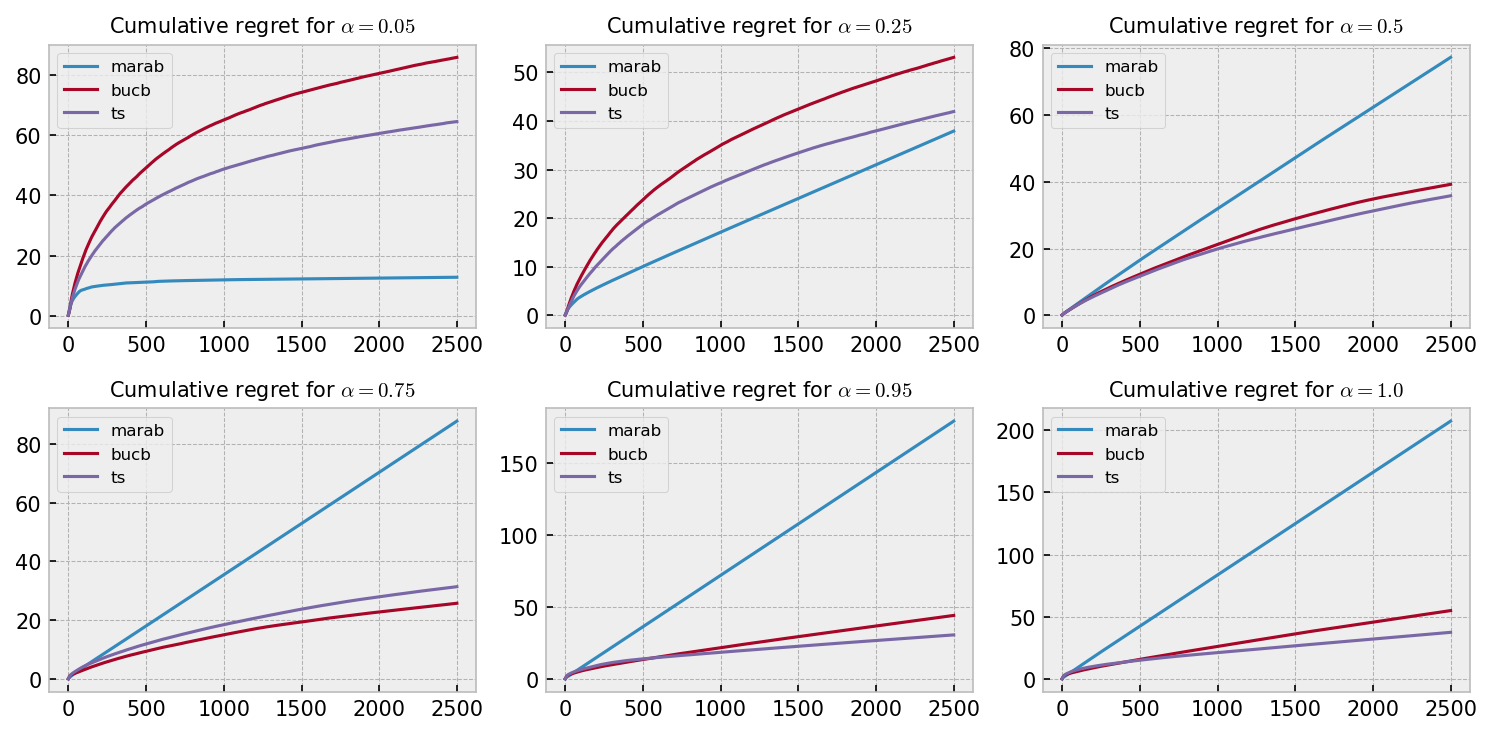

In [19]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 5), dpi=150)

# loop for each alpha
for k, alpha in enumerate([0.05, 0.25, 0.50, 0.75, 0.95, 1.00]):

    # adding as a subplot
    plt.subplot(2, 3, k + 1)
    
    # loop for each decision policy
    for i, policy in enumerate(['marab','bucb','ts']):

        # plotting average cumulative regret
        plt.plot(np.cumsum(results_dict[alpha][policy]['regret_array'],axis=1).mean(axis=0), label=policy, linewidth=1.5, color='C' + str(i));

        # plotting individual simulations
        #plt.plot(np.cumsum(results_dict[alpha][policy]['regret_array'],axis=1).T, color='C' + str(i), alpha=0.2, linewidth=1.0)
    
    # adding title
    plt.title('Cumulative regret for $\\alpha = {}$'.format(alpha), fontsize=10)

    # adding legend
    plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)
plt.tight_layout()

# showing plot
plt.show()

### Rewards and risks

Next, let us analyze rewards over time for some simulations. The following plots compare rewards over time for one simulation with $\alpha = 1.00$ with other simulations with lower $\alpha$'s. In the upper left corner, we can analyze rewards over time for $\alpha = 1.00$ vs. $\alpha = 0.05$, using Thompson Sampling. We can see that the volatility of rewards is much greater for $\alpha = 1.00$, as well as the average reward. The same analysis applies to the other plots up until the one on the lower right corner, which shows the same rewards over time pattern for $\alpha = 1.00$ and $\alpha = 0.75$, as the optimal bandit is the same for both cases.

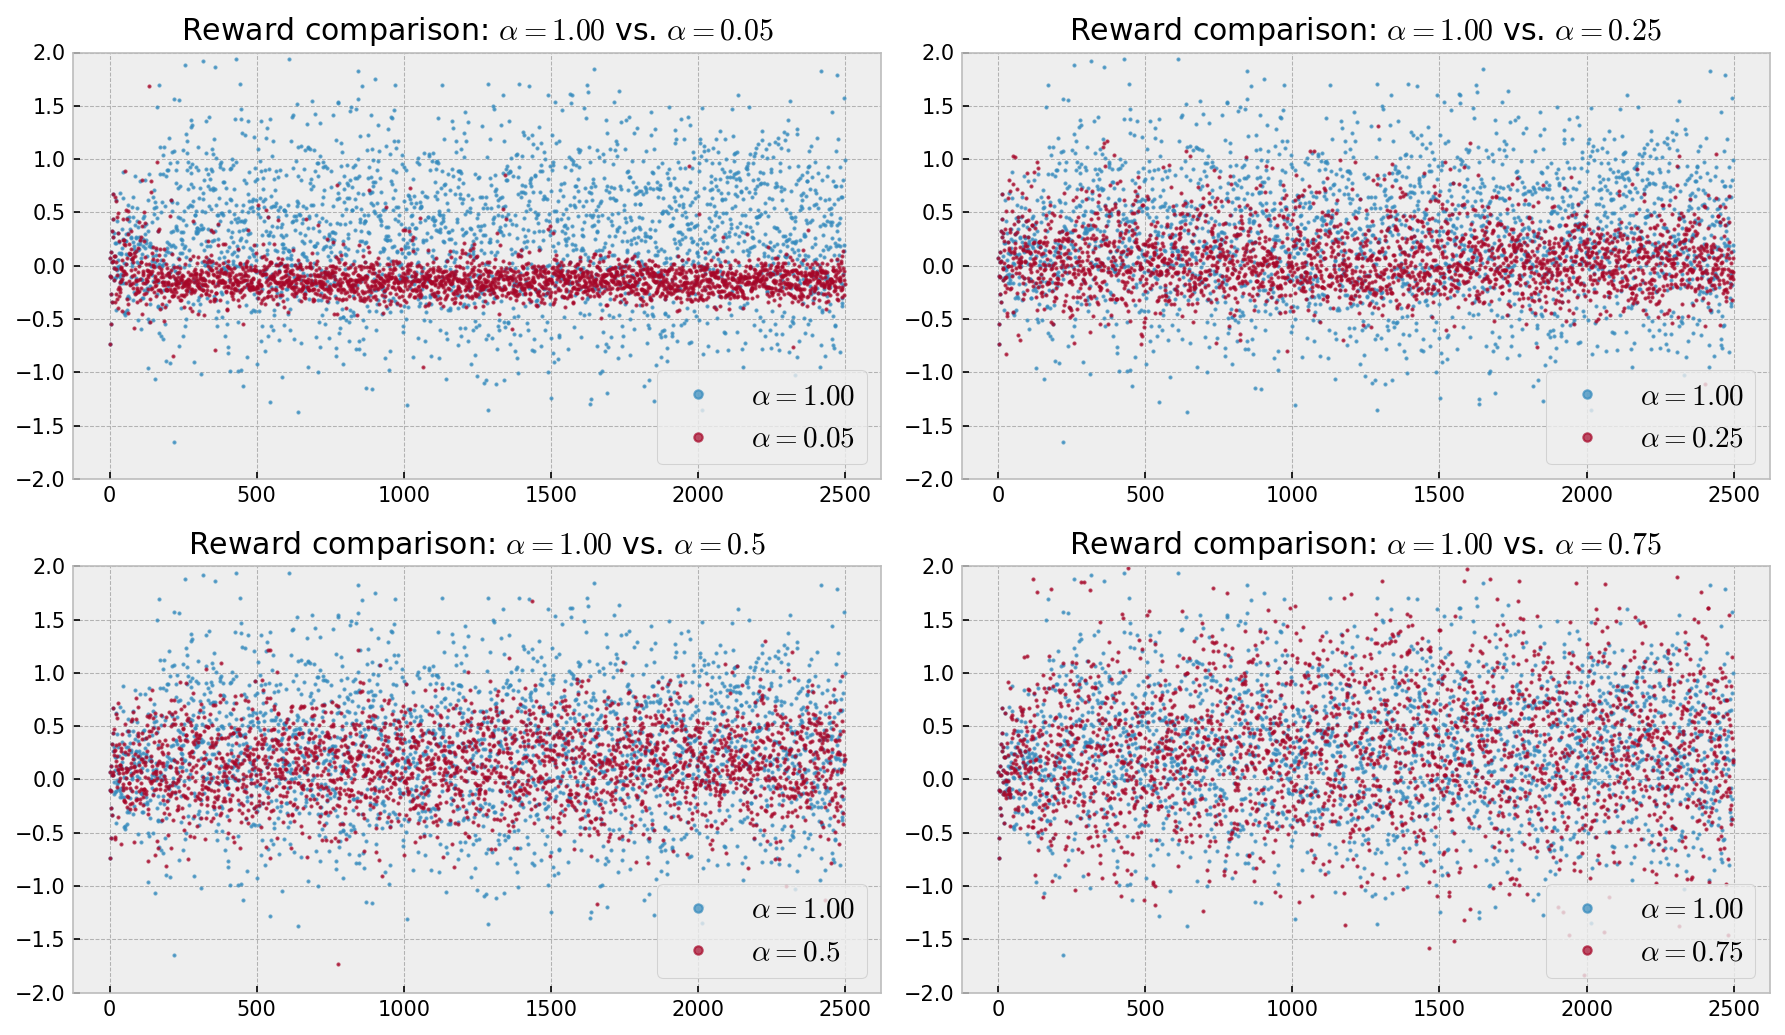

In [20]:
# opening figure
plt.figure(figsize=(12,7), dpi=150)

# loop for each alpha
for k, alpha in enumerate([0.05, 0.25, 0.50, 0.75]):

    # adding as a subplot
    plt.subplot(2, 2, k + 1)
    
    # plotting rewards for alpha = 1.00
    plt.plot(np.array(results_dict[1.00]['ts']['reward_array']).sum(axis=1)[0,:], 
             color='C0', alpha=0.7, marker='o', lw=0, ms=1, label='$\\alpha = 1.00$');
    
    # plotting moving average
    #plt.plot(pd.Series(np.array(results_dict[1.00]['ts']['reward_array']).sum(axis=1)[0,:]).rolling(200).mean(), 
    #         color='C0', alpha=1.00, lw=2);
    
    # plotting rewards for other alpha
    plt.plot(np.array(results_dict[alpha]['ts']['reward_array']).sum(axis=1)[0,:], 
             color='C1', alpha=0.7, marker='o', lw=0, ms=1, label='$\\alpha = {}$'.format(alpha));
    
    # plotting moving average
    #plt.plot(pd.Series(np.array(results_dict[alpha]['ts']['reward_array']).sum(axis=1)[0,:]).rolling(200).mean(), 
    #         color='C1', alpha=1.00, lw=2);
  
    # formatting
    plt.title('Reward comparison: $\\alpha = 1.00$ vs. $\\alpha = {}$'.format(alpha))
    plt.ylim(-2,+2); plt.tight_layout(); plt.legend(fontsize=14, markerscale=4)

## Conclusion

In this tutorial, we added a little bit of complexity to the classical multi-armed bandit problem with gaussian rewards by including a risk-averse incentive to the player. We measured the player's regret using Conditional Value-at-Risk $\textrm{CVaR}_{k}(\alpha)$, which is the average reward of the worst $\alpha \times 100\%$ outcomes the reward distribution can have. To make things more interesting, we defined problem such that the bandits with higher rewards also had higher risks, setting up a risk-reward compromise.

To solve this problem, we used the MaRab algorithm from [Galichet et. al (2013)](http://proceedings.mlr.press/v29/Galichet13.pdf), along with Thompson Sampling [(Van Roy et. al, 2018)](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf) and Bayesian UCB [(Kaufmann et. al ,2012)](http://proceedings.mlr.press/v22/kaufmann12/kaufmann12.pdf). MaRaB showed a very conservative behavior with little exploration, showing best results when the player is more risk-averse (lower $\alpha$), while Bayesian UCB and Thompson Sampling featured more exploration and better performance on risk-prone scenarios (higher $\alpha$). Overall, Thompson Sampling showed the best results. Finally, maximizing CVaR seemed a good strategy to control risk, as optimal bandits at lower $\alpha$'s showed much less volatile reward distributions.

As usual, full code is available on my [GitHub](https://github.com/gdmarmerola/advanced-bandit-problems). Hope you enjoyed the tutorial!